## YOLO runned on a video
#### create network

In [55]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt

class yoloDetector():
    
    def __init__(self,img,weights="\yolov4.weights",cfgnet="\yolov4.cfg",scale =0.00392):
        
        self.Width  = img.shape[1]
        self.Height = img.shape[0]   
        self.classpath = os.getcwd()[:-7]+ "cfg\coco.names"
        self.cfgpath = os.getcwd()[:-7]+ "cfg"
        self.weightspath = self.cfgpath + weights
        self.confignet = self.cfgpath+cfgnet 
        self.scale = scale
        self.classes = None
        
        with open(self.classpath, 'r') as f:
            self.classes = [line.strip() for line in f.readlines()]

        # only for testing. 80x3x255 -> rgb
        self.COLORS = np.random.uniform(0, 255, size=(len(self.classes), 3))

        # read pre-trained model and config file
        self.net = cv2.dnn.readNet(self.weightspath, self.confignet)


        #this fixes the input size
        blob = cv2.dnn.blobFromImage(img, self.scale, (416,416), (0,0,0), True, crop=False)
        self.net.setInput(blob)
        
        self.output_layers = self.get_output_layers(self.net)
        
        
    def get_output_layers(self,net):

        layer_names = net.getLayerNames()

        #yolov3 has 3 uoutlayers. yolov4
        x = net.getUnconnectedOutLayers()
        output_layers = [layer_names[i- 1] for i in net.getUnconnectedOutLayers()]

        return output_layers

    # function to draw bounding box on the detected object with class name
    def draw_bounding_box(self,img, class_id, confidence, x, y, x_plus_w, y_plus_h):

        label = str(self.classes[class_id])

        color = self.COLORS[class_id]
                            #(startpoint),(endpoint)
        cv2.rectangle(img, (x,y), (x_plus_w,y_plus_h), color, 2)

        cv2.putText(img, label, (x-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

        return img

    
    def infer(self,img):
        
        blob = cv2.dnn.blobFromImage(img, self.scale, (416,416), (0,0,0), True, crop=False)
        self.net.setInput(blob)
        outs = self.net.forward(self.output_layers)

        # initialization
        class_ids = []
        confidences = []
        boxes = []
        conf_threshold = 0.5
        nms_threshold = 0.4

        # for each detetion from each output layer 
        # get the confidence, class id, bounding box params
        # and ignore weak detections (confidence < 0.5)
        for out in outs:                       #one out is a dimxdimx(255= B*(classes+5=attributes of boundbox))
            for detection in out:              #3 outputs per image, each out 3 bounding boxes(?)
                scores = detection[5:]         #scores of the classes
                class_id = np.argmax(scores)   #most likely class
                confidence = scores[class_id]  #likelyhood of that one
                if confidence > 0.5:
                    center_x = int(detection[0] * self.Width)
                    center_y = int(detection[1] * self.Height) #starts top left and goes down
                    w = int(detection[2] * self.Width)
                    h = int(detection[3] * self.Height)
                    x = center_x - w / 2
                    y = center_y - h / 2
                    class_ids.append(class_id)
                    confidences.append(float(confidence))
                    boxes.append([x, y, w, h])
        
        # non-max suppression
        indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)

        # go through the detections remaining
        # after nms and draw bounding box
        detectImg = img
        #for showcase -> have to divide it into 6x10 -> if center of obj in one grid -> illuminate
        #add circle at center of grid-box and then gaussian blur 4each obj. if more obj, more illuminated
        phosphImg = np.copy(img)
        #print("img are the same: ", detectImg is phosphImg)
        
        #black
        phosphImg[:,:,:] = 0
        
        gridcounter = np.zeros((6,10))
        #i consider conventional notation for cartesian axes
        gridx = np.round(np.linspace(0,self.Width,11)) #10
        gridy = np.round(np.linspace(0,self.Height,7)) #6
        
        for i in indices:
            i = i
            box = boxes[i]
            x = box[0]
            y = box[1]
            w = box[2]
            h = box[3]
            detectImg = self.draw_bounding_box(detectImg, class_ids[i], confidences[i], round(x), round(y), round(x+w), round(y+h))
            
            #central pixel
            cenx = round(x + w/2)
            ceny = round(y +h/2)
            
            #check to which grid the center of the bounding box belongs.#gridy e x sono al contrario
            #print("ix1 is: ",(gridx<cenx).sum()-1, " ix2 is: ",(gridy<ceny).sum()-1)
            gridcounter[(gridy<ceny).sum()-1,(gridx<cenx).sum()-1] = gridcounter[(gridy<ceny).sum()-1,(gridx<cenx).sum()-1] + 1
         
        #gridx is now center pixel of each gridcell -> where to draw
        gridx = [round((gridx[i]+gridx[i+1])/2) for i in range(len(gridx)) if i < len(gridx)-1]
        gridy = [round((gridy[i]+gridy[i+1])/2) for i in range(len(gridy)) if i < len(gridy)-1]
        
        #remember first dimension = y
        wherey,wherex = np.nonzero(gridcounter)
        
        #ksize needs to be odd
        ksize = [round((gridx[1]-gridx[0])/4),round((gridy[1]-gridy[0])/4)]
        ksize[0] = ksize[0]-1 if ksize[0]%2 == 0 else ksize[0]
        ksize[1] = ksize[1]-1 if ksize[1]%2 == 0 else ksize[1]
        
        for i in range(len(wherex)): 
            #the more obj in one gridbox -> more ligth
            for j in range(round(gridcounter[wherey[i],wherex[i]])):
                #draw and smooth. radius = .5 of distance center-border = .25 distance border-border
               
                #some error with gridx and gridy !
                cv2.circle(phosphImg,(gridy[wherey[i]],gridx[wherex[i]]),radius=round((gridx[1]-gridx[0])/4),color=[255,255,255],thickness=-1)
                #blur. row = primo indice = y. center +- .5 distance
                upY = round(gridy[wherey[i]]-(gridy[1]-gridy[0])/2) #y scende da alto vs basso, upbound in quel senso
                lowY = round(gridy[wherey[i]]+(gridy[1]-gridy[0])/2)
                lowX = round(gridx[wherex[i]]-(gridx[1]-gridx[0])/2) 
                upX = round(gridx[wherex[i]]+(gridx[1]-gridx[0])/2)
                
                phosphImg[upY:lowY,lowX:upX] =  cv2.GaussianBlur(phosphImg[upY:lowY,lowX:upX] ,ksize,0)
        
        return detectImg,phosphImg
        

#### BEWARE
- asse x(primo indice/dimensione di un immagine) è l'asse y al contrario
- asse y(secondo) è asse x normale

dimx is:  512  dimy is:  773
x is:  336  y is:  100


(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x144aac48048>)

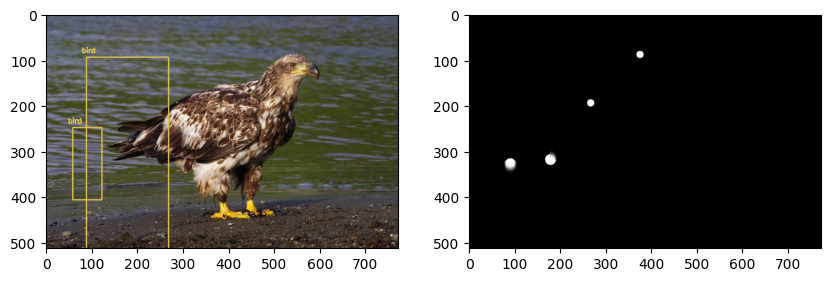

In [56]:
import cv2
from matplotlib import pyplot as plt
from matplotlib import figure
imgpath = r"C:\Users\Ale\PYEnv\env\JupyterLab\BionicSensesYolo\data\eagle.jpg"
img = cv2.imread(imgpath)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print("dimx is: ",img.shape[0]," dimy is: ",img.shape[1]) #row X col -> row = y
w = 100
y = round(100)#img.shape[0]/2-w/2)
x = round(img.shape[1]/2-w/2)
print("x is: ",x," y is: ",y)
#The standard deviation for a two-dimensional kernel is the radius in pixels containing 68% of the integrated magnitude of the coefficients.
#img[x:x+w,y:y+w] = cv2.GaussianBlur(img[y:y+w, x:x+w] ,(23,23),0)
#plt.imshow(img[:,:])

detector = yoloDetector(init_frame,weights="\yolov4-tiny.weights",cfgnet="\yolov4-tiny.cfg")
img,phosph = detector.infer(img)
fig = plt.figure(figsize=(10,8))
plt.subplot(121),plt.imshow(img)
plt.subplot(122),plt.imshow(phosph)


In [51]:
a = [i for i in range(4) if i%2==1]
a

[1, 3]

#### Video acquisition

- yolo4 circa 80 frames 5 secs -> 82 secondi -> tiny 9.2 secs !
- tiny 158 frames -> 18 sec  . yolo normale circa 160
- v4-tiny fa abbastanza schifo
- yolov4 -> 1 sec/frame  yolov4-tiny -> 0.12-0.09 sec/frame
    - se video 15 frame/sec -> 1.8 secondi per farli tutti 

In [48]:
import time

datapath = os.getcwd()[:-7]+"data"

videopath = datapath + '\inputVideo.mp4'
outpath = datapath + "\outVideo.avi"
outpath2 = datapath +"\phosphVideo.avi"

print("datapath is: ",datapath)

try:
    
    #reader
    cap = cv2.VideoCapture(videopath)
    
    fps = cap.get(cv2.CAP_PROP_FPS)      # OpenCV v2.x used "CV_CAP_PROP_FPS"
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = frame_count/fps
    print('fps = ' + str(fps))
    print('number of frames = ' + str(frame_count))
    print('duration (S) = ' + str(duration))
 
    #init detector
    init_ret,init_frame = cap.read()
    print("init_ret is: ",init_ret)
    
    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'XVID')  #*'MP4V' #'M','J','P','G'
    detector = yoloDetector(init_frame,weights="\yolov4-tiny.weights",cfgnet="\yolov4-tiny.cfg")
    print("video frame size = ",detector.Width," ",detector.Height)
    print("init frame shape: ",init_frame.shape)
    
    starttime = time.time()
    
    #specified dimension has to match with input !!
    out = cv2.VideoWriter(outpath, fourcc, 15.0, (init_frame.shape[1],init_frame.shape[0]))
    out2 = cv2.VideoWriter(outpath2,fourcc,15.0, (init_frame.shape[1],init_frame.shape[0]))

    skip = True
    while cap.isOpened():

        ret, frame = cap.read()
        # if frame is read correctly ret is True
        if not ret:
            print("Can't receive frame (stream end?). Exiting ...")
            break
        
        #skip 50% of frames -> video 
        skip = not skip
        if skip:
            continue
            
        frame,phosphFrame = detector.infer(frame)        
        # write processed frame
        out.write(frame)
        out2.write(phosphFrame)

        #exit loop
        if cv2.waitKey(1) == ord('q'):    
            break

finally:
    
    print("elapsed: ",time.time()-starttime) 
    cap.release()                            
    out.release()
    out2.release()
    cv2.destroyAllWindows()

datapath is:  C:\Users\Ale\PYEnv\env\JupyterLab\BionicSensesYolo\data
fps = 30.020013342228154
number of frames = 158
duration (S) = 5.263155555555556
init_ret is:  True
video frame size =  352   640
init frame shape:  (640, 352, 3)
Can't receive frame (stream end?). Exiting ...
elapsed:  9.667568445205688


In [46]:
import numpy as np

a = np.ones((2,3))
b = a[:]
b is a
b[0]=0
a

array([[0., 0., 0.],
       [1., 1., 1.]])

In [82]:
import numpy as np
k = np.zeros((5,5))
a = np.linspace(0,20,6)
print(a)
x = 7
c= a< x 
d = c.sum()
h = np.round(np.linspace(0,20,7))
print(h)
y = 9
c1 = h < y
j = c1.sum()
#d =2 -> seconda grid
k[d-1,j-1] = k[d-1,j-1] +1
k[(np.linspace(0,20,6) < x).sum()-1,(np.linspace(0,20,6) < y).sum()-1] = k[(np.linspace(0,20,6) < x).sum()-1,(np.linspace(0,20,6) < y).sum()-1] +1

d = [round((a[i]+a[i+1])/2) for i in range(len(a)) if i<len(a)-1]
print(d)
k[4,4]=1
print(k)
wherex,wherey = np.nonzero(k)
print(wherex)
print(wherey)
print(k[wherex,wherey])

for x in range(len(wherex)):
    print(k[wherex[x],wherey[x]])
    print("wherex",wherex[x]) #indices to access gridx
    print("wherey",wherey[x])
    for j in range(round(k[wherex[x],wherey[x]])):
        pass
    

[ 0.  4.  8. 12. 16. 20.]
[ 0.  3.  7. 10. 13. 17. 20.]
[2, 6, 10, 14, 18]
[[0. 0. 0. 0. 0.]
 [0. 0. 2. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]]
[1 4]
[2 4]
[2. 1.]
2.0
wherex 1
wherey 2
1.0
wherex 4
wherey 4
